**Before you begin, execute the notebook with "Run all"!**

This will download the simulation data, look-up-tables and Python modules you'll need throughout this session, so you won't have to wait later.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
# gdown -> download data and python modules
! pip install --upgrade --quiet gdown
# install the Pylians library
! pip install h5py pyfftw cython Pylians

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached hdf5plugin-5.1.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.7 kB)
  Using cached Cython-0.29.37-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.9 MB/s eta 0:00:00
Using cached Cython-0.29.37-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
Using cached hdf5plugin-5.1.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.9 MB)
  Created wheel for Pylians: filename=pylians-0.12-cp311-cp311-linux_x86_64.whl size=8535902 sha256=c2280b8df9a1fcf9c2301ef7b7b0da93ec0e72b69f9ca2968e11cf7fcdc93b0a
  Stored in directory: /root/.cache/pip/wheels/5c/a7/14/17ac7418fab6664836ade06be7092461e366fee

In [ ]:
import gdown
import zipfile

# Google Drive link with simulations
sims_drive_link = "https://drive.google.com/file/d/1fmcqEVJQK1_dyaqRC8vqfPvDUEJCjCZ4/view?usp=sharing"

# Convert the link to a direct download format
file_id = sims_drive_link.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
destination = 'downloaded'

# Download the file
gdown.download(download_url, destination, quiet=False)
print(f"\nFile downloaded to: {destination}")

# Now unzip
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('./')


Downloading...
From (original): https://drive.google.com/uc?id=1fmcqEVJQK1_dyaqRC8vqfPvDUEJCjCZ4
From (redirected): https://drive.google.com/uc?id=1fmcqEVJQK1_dyaqRC8vqfPvDUEJCjCZ4&confirm=t&uuid=ec681cd1-05e6-4c1a-a15f-c4b779806aae
To: /content/downloaded
100%|██████████| 1.59G/1.59G [00:20<00:00, 78.7MB/s]



File downloaded to: downloaded


In this session, we'll *emulate* the large-scale structure of the Universe under modified gravity (MG), using a simulation originally run in standard ΛCDM cosmology.

An **emulator** is a tool that transforms one dataset into another that would otherwise require expensive or time-consuming computation. In our case, we'll take a ΛCDM simulation and apply transformations to approximate what the Universe would look like under a different theory of gravity.

This exercise will help you understand how large-scale structure can change under a different theory of gravity.

We'll follow analytical rescaling techniques introduced by [Angulo & White (2010)](https://academic.oup.com/mnras/article/405/1/143/1020967), and extended to modified gravity models by [Mead et al. (2015)](https://academic.oup.com/mnras/article/452/4/4203/1056283).  
To keep run times manageable, we’ll be using a small, low-resolution simulation with $N=128^3$ particles and box size $L = 250 \, \mathrm{Mpc}/h$.

---

Have a sneaky peak at the simulations first. They are:
* a simulation run under GR (Euclid reference cosmology)
* a simulation run under $f(R)$ (same parameters, plus $|f(R_0)|=10^{-5}$)
* a simulation run under nDGP (same parameters, plus $H_0 r_c = 0.5$)

/tmp/ipython-input-4-3928528391.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray_cmap = cm.get_cmap("gray_r")


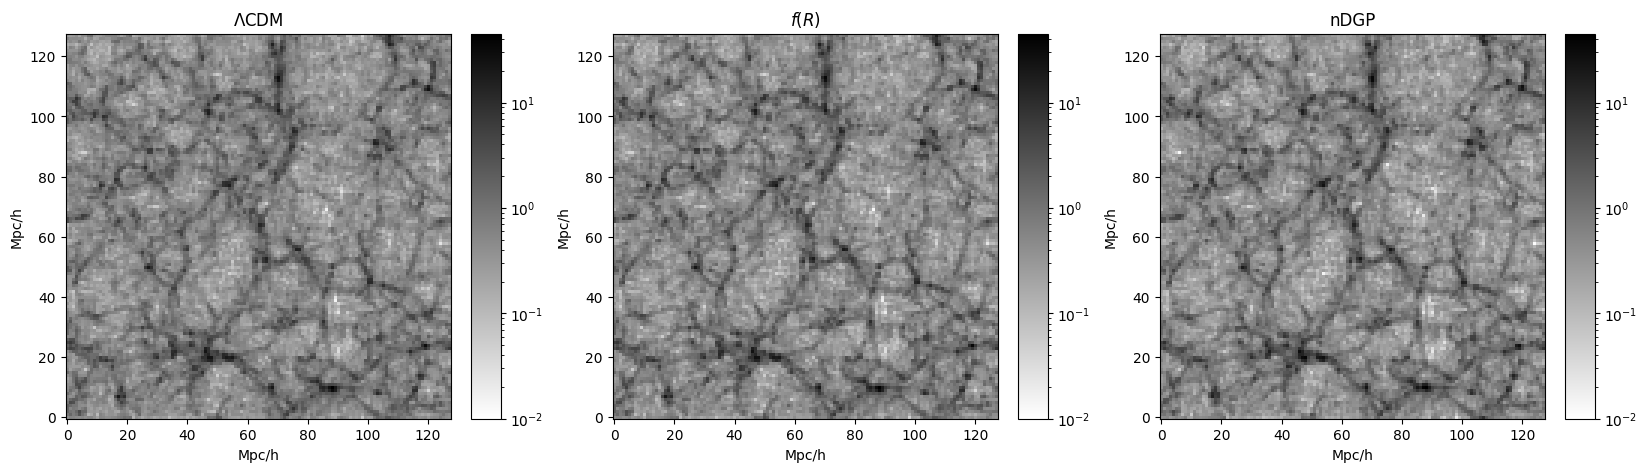

In [ ]:
# visualise one same slice in the three simulations (they were chosen to have the same initial conditions
# so that they are easier to compare).
# to do that, reconstruct the density field first - we can use Pylians for this
import readgadget
import MAS_library as MASL
from matplotlib.colors import LogNorm
from matplotlib import cm

N, L = 128, 250.
OmegaM = 0.319

def get_delta( pos=None, snap_path=None, MAS="CIC" ):
    if pos is None:
        if snap_path is not None:
            pos = readgadget.read_block( snap_path, "POS ", ptype=[1] )
        else:
            message = "You must provide either a vector of positions or the path to a snapshot!"
            raise ValueError(message)
    else:
        pos = np.asarray(pos, dtype=np.float32, order='C')

    rhoN = np.zeros((N,N,N), dtype=np.float32)
    MASL.MA( pos, rhoN, L, MAS=MAS, verbose=False)
    # overdensity: conversion to float64 is done so that DC mode of FFT is actually 0
    delta = rhoN / np.mean( rhoN.astype(np.float64) ) - 1
    delta = delta.astype(np.float32)
    return delta

LCDM_snap_path = "data/sims/LCDM/output/snapshot_LCDM_z0.000/gadget_z0.000"
fofR_snap_path = "data/sims/FOFR/output/snapshot_FOFR_z0.000/gadget_z0.000"
nDGP_snap_path = "data/sims/nDGP/output/snapshot_nDGP_z0.000/gadget_z0.000"
snap_paths = [ LCDM_snap_path, fofR_snap_path, nDGP_snap_path ]
titles = [ r'$\Lambda$CDM', r'$f(R)$', 'nDGP' ]

z = 70
dz = 15

# grayscale colourmap
gray_cmap = cm.get_cmap("gray_r")
# use one same scale for the colourbar
vmin, vmax = 0.01, 45
# logarithmic colourbar
norm = LogNorm(vmin=vmin, vmax=vmax)

# to save memory, we will load, plot then delete the overdensities of one field at a time
fig, axes = plt.subplots(1,3, figsize=(20,5))
for i, snap_path in enumerate(snap_paths):
    delta = get_delta( snap_path=snap_path )
    # average over the third dimension so that we can visualise the slide in 2D
    delta_2D = np.mean( 1 + delta[:,:,z:z+dz], axis=-1 )
    cbar = axes[i].imshow( delta_2D, origin='lower', cmap=gray_cmap, norm=norm )
    cax = fig.add_axes([ axes[i].get_position().x1+0.01, axes[i].get_position().y0,
                    0.015, axes[i].get_position().height])
    plt.colorbar( cbar, cax=cax )
    axes[i].set_xlabel('Mpc/h')
    axes[i].set_ylabel('Mpc/h')
    axes[i].set_title(titles[i])


This comparison might feel underwhelming. Let's use animations to highlight small differences between snapshots. Let's also project the entire box, as opposed to just a slice

In [ ]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML




def animate_compare(data1, data2, name1, name2, interval=500, vmin=None, vmax=None, dpi=150, figsize=(4, 4)):
    """
    Animate two 2D datasets back and forth using imshow on a single axis with high-resolution grayscale colormap and logarithmic color scaling.

    Controls:
    - Left-click or press space to pause/resume.

    Parameters:
    - data1, data2: np.ndarray of shape (N, N)
    - name1, name2: titles for each dataset
    - interval: time between frames in ms
    - vmin, vmax: color scale limits (if None, computed from both datasets)
    - dpi: resolution of the figure in dots per inch
    - figsize: figure size in inches (width, height)

    Returns:
    - FuncAnimation object (display with HTML(ani.to_jshtml()))
    """
    if data1.shape != data2.shape:
        raise ValueError("data1 and data2 must have the same shape")

    # Compute color limits if not provided
    if vmin is None or vmax is None:
        combined = np.stack([data1, data2])
        vmin = np.min(combined) if vmin is None else vmin
        vmax = np.max(combined) if vmax is None else vmax

    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    gray_cmap = cm.get_cmap("gray_r")
    norm = LogNorm(vmin=vmin, vmax=vmax)

    # Initial image
    img = ax.imshow(data1, origin='lower', cmap=gray_cmap, norm=norm)
    ax.set_title(name1)
    ax.set_xlabel('Mpc/h')
    ax.set_ylabel('Mpc/h')

    # Use make_axes_locatable to create a stable colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax)

    paused = False

    def init():
        img.set_data(data1)
        ax.set_title(name1)
        return img,

    def update(frame):
        if frame % 2 == 0:
            img.set_data(data1)
            ax.set_title(name1)
        else:
            img.set_data(data2)
            ax.set_title(name2)
        return img,

    # Pause/resume handlers
    def on_click(event):
        nonlocal paused
        paused = not paused

    def on_key(event):
        nonlocal paused
        if event.key == ' ':
            paused = not paused

    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.canvas.mpl_connect('key_press_event', on_key)

    # Frame generator
    def frame_gen():
        for i in range(10):  # Only yield 10 frames
            yield i

    # Create animation
    ani = FuncAnimation(
        fig, update, frames=frame_gen, init_func=init,
        interval=interval, blit=False)

    # Close static display
    plt.close(fig)
    return ani


In [ ]:
z = 0; dz = 128
delta_fofR = get_delta( snap_path=fofR_snap_path )
delta_LCDM = get_delta( snap_path=LCDM_snap_path )
delta_fofR_2D = np.mean(1 + delta_fofR[:,:,z:z+dz], axis=-1)
delta_LCDM_2D = np.mean(1 + delta_LCDM[:,:,z:z+dz], axis=-1)
ani = animate_compare(delta_fofR_2D, delta_LCDM_2D, "$f(R)$", "$\Lambda$CDM" )
HTML(ani.to_jshtml())


/tmp/ipython-input-5-2761352489.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray_cmap = cm.get_cmap("gray_r")
/tmp/ipython-input-5-2761352489.py:86: UserWarning: frames=<function animate_compare.<locals>.frame_gen at 0x784d59776b60> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(


In [ ]:
z = 0; dz = 128
delta_nDGP = get_delta( snap_path=nDGP_snap_path )
delta_LCDM = get_delta( snap_path=LCDM_snap_path )
delta_nDGP_2D = np.mean(1 + delta_nDGP[:,:,z:z+dz], axis=-1)
delta_LCDM_2D = np.mean(1 + delta_LCDM[:,:,z:z+dz], axis=-1)
ani = animate_compare(delta_nDGP_2D, delta_LCDM_2D, "nDGP", "$\Lambda$CDM" )
HTML(ani.to_jshtml())

/tmp/ipython-input-5-2761352489.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray_cmap = cm.get_cmap("gray_r")
/tmp/ipython-input-5-2761352489.py:86: UserWarning: frames=<function animate_compare.<locals>.frame_gen at 0x784d593a4540> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(


By eye, the simulations all look quite similar, but there's more to it *than meets the eye!*. Let's have a look at statistical properties like the power spectrum and the bispectrum.
In these cells you find the paths to files detailing the *full-* and *linear* matter power spectra and the bispectrum, as computed by the library that run the simulations (FML). Plot them and compare them - we suggest showing the ratio MG/$\Lambda$CDM, for easier interpretation.

How do the three power spectra compare? What is the linear prediction missing?

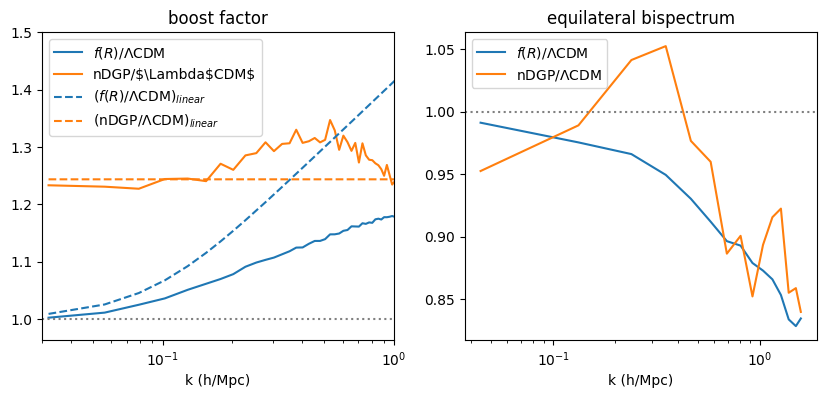

In [ ]:
LCDM_k, LCDM_Pk, LCDM_lin_Pk = np.loadtxt( "data/sims/LCDM/output/pofk_LCDM_cb_z0.000.txt", usecols=(0,1,2), unpack=True )
fofR_k, fofR_Pk,fofR_lin_Pk = np.loadtxt( "data/sims/FOFR/output/pofk_FOFR_cb_z0.000.txt", usecols=(0,1,2), unpack=True )
nDGP_k, nDGP_Pk, nDGP_lin_Pk = np.loadtxt( "data/sims/nDGP/output/pofk_nDGP_cb_z0.000.txt", usecols=(0,1,2), unpack=True )

# equilateral configuration of the reduced bispectrum, use theory = 'LCDM', 'FOFR', 'nDGP'
def extract_equilateral( theory ):
    bispectrum_file = f"data/sims/{theory}/output/snapshot_{theory}_z0.000/bispectrum_z0.000.txt"
    try:
        # bin indices, k, Qk
        ii, jj, kk, k, Qk = np.loadtxt( bispectrum_file, usecols=(0,1,2,3,-2), unpack=True )
        # select the entries with equal bin indices
        eq = ( ii == jj ) & ( ii == kk )
        return k[eq], Qk[eq]
    except FileNotFoundError:
        print("Are you sure that is a good theory name?")

LCDM_k_eq, LCDM_Qk_eq = extract_equilateral( 'LCDM' )
fofR_k_eq, fofR_Qk_eq = extract_equilateral( 'FOFR' )
nDGP_k_eq, nDGP_Qk_eq = extract_equilateral( 'nDGP' )


fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot( fofR_k, fofR_Pk / LCDM_Pk, 'C0', label=r"$f(R)$/$\Lambda$CDM" )
axes[0].plot( nDGP_k, nDGP_Pk / LCDM_Pk, 'C1', label=r"nDGP/$\Lambda$CDM$" )
axes[0].plot( fofR_k, fofR_lin_Pk / LCDM_lin_Pk, 'C0--', label=r"($f(R)$/$\Lambda$CDM)$_{linear}$" )
axes[0].plot( nDGP_k, nDGP_lin_Pk / LCDM_lin_Pk, 'C1--', label=r"(nDGP/$\Lambda$CDM)$_{linear}$" )
axes[0].axhline( 1, c='gray', ls=':')
axes[0].set_ylim( ymax=1.5 )
axes[0].set_xlim( 3e-2,1 )
axes[0].set_xlabel('k (h/Mpc)')
axes[0].set_xscale('log')
axes[0].legend();
axes[0].set_title("boost factor")

axes[1].plot( fofR_k_eq, fofR_Qk_eq / LCDM_Qk_eq, label=r"$f(R)$/$\Lambda$CDM" )
axes[1].plot( nDGP_k_eq, nDGP_Qk_eq / LCDM_Qk_eq, label=r"nDGP/$\Lambda$CDM" )
axes[1].set_xscale('log')
axes[1].set_xlabel('k (h/Mpc)')
axes[1].set_title("equilateral bispectrum")
axes[1].axhline( 1, c='gray', ls=':')
axes[1].legend();


Angulo & White (2010) showed that it's possible to transform a ΛCDM simulation into one with slightly different cosmological parameters. This is done by appropriately rescaling:

- lengths  
- velocities  
- masses  
- and relabelling redshift  

They also improved large-scale accuracy by adjusting particle positions and velocities using the **Zel’dovich approximation**.

---

<details>
  <summary><strong>What is the Zel’dovich Approximation?</strong></summary>

The **Zel’dovich approximation (ZA)** is a first-order Lagrangian perturbation theory used to model the emergence of large-scale structure in the Universe. Introduced by Yakov Zel’dovich in 1970, it bridges the gap between linear theory and full nonlinear simulations.

It works well in the **linear regime** (where density fluctuations $\delta \ll 1$) and into the **quasi-nonlinear regime** (before particle crossings).

**Eulerian vs. Lagrangian perspectives:**

- *Eulerian*: track fields at fixed positions $\mathbf{x}, t$
- *Lagrangian*: track individual fluid elements from initial coordinates $\mathbf{q}$

In the Lagrangian approach, particle positions are expressed as:

$$
\mathbf{x}(\mathbf{q}, t) = \mathbf{q} + \mathbf{\Psi}(\mathbf{q}, t)
$$

where:
- $\mathbf{q}$ is the initial (Lagrangian) coordinate  
- $\mathbf{\Psi}$ is the **displacement field**

Under the Zel’dovich approximation, this becomes:

$$
\mathbf{x}(\mathbf{q}, t) = \mathbf{q} + D(t)\,\mathbf{s}(\mathbf{q})
$$

where:
- $D(t)$ is the linear growth factor  
- $\mathbf{s}(\mathbf{q}) = -\nabla_q \Phi_0(\mathbf{q})$ is the initial displacement direction

As $D(t) \to 0$, $\mathbf{x} \to \mathbf{q}$ — particles start at their initial positions. As structures grow, particles move along $\mathbf{s}$ toward overdensities.

The approximation is powerful because it **separates time and space**, making early structure formation analytically tractable.

For more, see [this quick description](https://fisica.usac.edu.gt/public/curccaf_proc/borganihtml/node4.html) or the full review in Bernardeau et al., *Phys. Rept.* **367**, 1 (2002).

</details>

---

Building on this, Mead et al. (2015) applied these ideas to modified gravity models. They started with simulations that had high clustering (to mimic the effects of extra gravitational force) and transformed them to resemble simulations run under *f(R)* gravity. They enhanced the large-scale behavior using scale-dependent corrections from the Zel’dovich approximation and improved the redshift space distortions by tweaking halo properties like concentration and velocity dispersion.

In this notebook we will follow this approach.

The first step is to run a *parent* ΛCDM simulation with an intentionally high clustering amplitude (i.e. large $\sigma_8$; we will use $\sigma_8=1.2$). The idea is that such a large-clustering simulation can look like lower-clustering simulations *earlier in time*. By stopping this simulation earlier — and then appropriately rescaling its distances and masses — we can bring its output closer to our target cosmology. The key is to identify the precise scaling factor and redshift that minimize the differences between the two universes.

---

**Question 1:**  
In linear theory, how does the matter power spectrum $P(k)$ change when $\sigma_8$ is increased or decreased (with all other parameters held fixed)?  
What changes in the *shape* of $P(k)$ — if any — do you expect?

What about the *nonlinear* power spectrum?  
How does increasing $\sigma_8$ affect $P(k)$ on small scales, and why does this differ from the linear case?

You can verify your expectations by plotting the two *linear* power spectra at the following files:

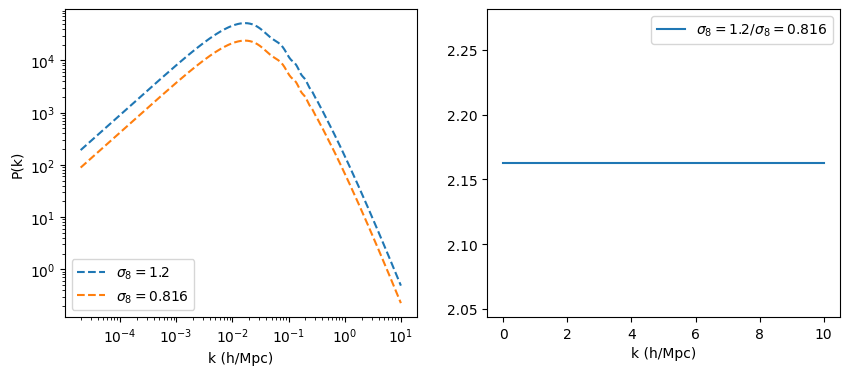

In [ ]:
big_sigma_Pk_file = "data/big_sigma_linear_Pk.npy"
bk, bPk = np.load( big_sigma_Pk_file )

LCDM_lin_Pk_file = "data/LCDM_linear_Pk.npy"
k, LCDM_lin_Pk = np.load( LCDM_lin_Pk_file )

fig, axes = plt.subplots( 1, 2, figsize=(10,4) )
axes[0].loglog( bk, bPk, '--', label=r"$\sigma_8=1.2$" )
axes[0].loglog( k, LCDM_lin_Pk, '--', label=r"$\sigma_8=0.816$" )
axes[0].set_xlabel('k (h/Mpc)')
axes[0].set_ylabel('P(k)')
axes[0].legend()

axes[1].plot( k, bPk / LCDM_lin_Pk, label=r"$\sigma_8=1.2/\sigma_8=0.816$" )
axes[1].set_xlabel('k (h/Mpc)')
axes[1].legend()

**Question 2:**  
In a modified gravity (MG) model, where all other cosmological parameters are held fixed, how would you expect $\sigma_8$ to differ from that in GR? Why?  

Given that structure grows differently in MG, researchers often define $\sigma_8$ in MG as the value the model *would have* if it followed GR evolution. Why is this useful? How would you compare the MG and GR models fairly using this approach?

---

Let ${R_1}^{\prime}$ and ${R_2}^{\prime}$ be two comoving scales within which we'd like linear clustering to match as close as possible. We can then find the parameters $s$ and $z^{\star}$ that minimise the cost function:

$\delta^2_{\mathrm{rms}}(s, z^{\star} \mid z') = \frac{1}{\ln(R_2'/R_1')} \int_{R_1'}^{R_2'} \frac{dR}{R} \left[ 1 - \frac{\sigma(R/s, z^{\star})}{\sigma'(R, z')} \right]^2$

(see Eq.(33) of Mead et al.).

In this equation, $\sigma(R,z)$ is defined as:

$\sigma^2(R, z) = \int D^2(k, z) \left( \frac{k^3}{2\pi^2} P_{\rm lin}(k) \right) W^2(kR) \, \mathrm{d} \ln k$

with

$W(x) = \frac{3}{x^3}(\sin x - x \cos x)$

and where $D$ is the *linear* growth factor and $P_{\rm lin}(k)$ is the *linear* matter power spectrum, both of which can be computed using perturbation theory. $D$ brings the power spectrum to the desired redshift, and, for modified gravity theories, it is in general scale dependent, unlike in ΛCDM. The parameter $\sigma_8$ is $\sigma(8\text{ Mpc}/h,z=0)$.

The function `delta2_rms` has been coded for you (you can read the code in `find_rescalings.py`, which is included in the modules). It will use linear matter power spectra, computed using CAMB, for a Euclid reference cosmology. Run the cell below to find the rescaling parameters $s$ and $z^{\star}$.

In [ ]:
big_sigma_lin_Pk_data = np.load("data/big_sigma_linear_Pk.npy")
tgt_lin_Pk_data = np.load("data/MG_linear_Pk.npy") # this is an F5 cosmology

We will choose ${R_1}^{\prime}$ and ${R_2}^{\prime}$ such that they correspond to the sizes of dark matter haloes containing $n_{p,\mathrm{min}}$ and $n_{p,\mathrm{max}}$ particles, respectively — assuming the haloes had uniform density (which, of course, they don’t!).

The numbers below are reasonable for the low-resolution simulations we use in this practical session.

In [ ]:
np_min = 20
np_max = 2526

def R_of_np( n_p, N=128, L=250. ):
    # R is the radius of a sphere containing n_p particles
    # (assuming a uniform distribution of particles)
    return np.cbrt( 3 * n_p / (4*np.pi) ) * L / N

In [ ]:
# these are pre-computed look-up tables (LUT) for the linear growth factor in LCDM and F5

from scipy.interpolate import RegularGridInterpolator, interp1d

def get_LCDM_D_interpolator( a_values="LCDM_LUT_a_values.npy", D_values="LCDM_LUT_D_values.npy" ):
    a = np.load( a_values )
    D = np.load( D_values )
    D_interp = interp1d( a, D )
    return D_interp

# valid for F5 only
def get_fR_D_interpolator( a_values="fR_LUT_a_values.npy", k_values="fR_LUT_k_values.npy", D_table="fR_LUT_D_table.npy" ):
    a = np.load( a_values )
    k = np.load( k_values )
    D = np.load( D_table )
    D_interp = RegularGridInterpolator( (k,a), D, method='linear' )
    return D_interp

In [ ]:
from scipy.integrate import quad, fixed_quad
from scipy.optimize import minimize

def get_sigma_of_R_z( R, z, D_interpolator, lin_Pk_data, scale_dep=False ):
    # scale-dep is whether we are passing a scale-dependent growth interpolator
    a = 1./(1+z)

    # linear power spectrum at z, obtained from the linear power spectrum at z=0
    k, Pk_lin_orig = lin_Pk_data
    Pk_lin = np.copy(Pk_lin_orig)
    if scale_dep:
        D = D_interpolator((k,a))
    else:
        D = D_interpolator(a)
    Pk_lin *= D**2

    # interpolate _linear_ LCDM P(k)
    Pk_lin_interp = interp1d( k, Pk_lin )

    # X = kR; Fourier transform of spherical top-hat window function
    W = lambda X : 3.0 * ( np.sin(X) - X * np.cos(X) ) / X**3

    # sigma^2 at z=0, integrand function
    f = lambda k_, R_ : k_**2 * Pk_lin_interp(k_) * W(k_*R_)**2

    # sigma^2(R,z) - I use quad as it's adaptive
    sigma2 = quad(f, min(k), max(k), args=(R) )[0]  / (2.*np.pi**2)

    return np.sqrt( sigma2 )



# the function to minimise
def delta2_rms( x, np_min, np_max, LCDM_D, tgt_D,
               LCDM_lin_Pk_data, tgt_lin_Pk_data, z_tgt, **kwargs ):

    s, zstar = x # this is required by the minimisation routine
    R1 = R_of_np( np_min )
    R2 = R_of_np( np_max )
    sigma_rsc = lambda R_: get_sigma_of_R_z( R_/s, zstar, LCDM_D, LCDM_lin_Pk_data, scale_dep=False, **kwargs )
    sigma_tgt = lambda R_: get_sigma_of_R_z( R_, z_tgt, tgt_D, tgt_lin_Pk_data, scale_dep=True, **kwargs )

    # integrand function
    f = lambda R_: 1/R_ * ( 1 - sigma_rsc(R_) / sigma_tgt(R_) )**2
    f = np.vectorize(f)

    # just monitoring
    print( "\ns = ", s, " zstar = ", zstar )

    # Here I use quadrature (non-adaptive) because the integrand is smoother - this is MUCH faster
    delta2_rms, _ = fixed_quad(f, R1, R2, n=100)
    delta2_rms *= 1. / np.log(R2 / R1)
    print(f"delta2_rms = {delta2_rms:.2e}")


    return delta2_rms


def get_s_zstar( np_min, np_max, LCDM_lin_Pk_data, tgt_lin_Pk_data, disp=True, z_tgt=0,
                # initial guess:
                s_0=0.75, zstar_0=0.25 ):

    x0 = (s_0, zstar_0)

    # linear growth factor - this loads a precomputed look-up-table of linear growth factor
    # for f(R) and LCDM. They work for \Omega_M = 0.319 and |f(R_0)| = 1e-5
    LCDM_D = get_LCDM_D_interpolator( a_values="data/LUT/LCDM_LUT_a_values.npy",
                                    D_values="data/LUT/LCDM_LUT_D_values.npy" )
    fR_D = get_fR_D_interpolator( a_values="data/LUT/fR_LUT_a_values.npy",
                                 k_values="data/LUT/fR_LUT_k_values.npy",
                                 D_table="data/LUT/fR_LUT_D_table.npy" )

    # everything else the function needs to know
    args=( np_min, np_max, LCDM_D, fR_D, LCDM_lin_Pk_data, tgt_lin_Pk_data, z_tgt )
    #bounds = [ (0.5, 1.), (0., 0.5) ]

    res = minimize( delta2_rms, x0, args=args, options={'disp': True} ) #bounds=bounds, options={'disp': True} )
    print( f"best fit s: {res.x[0]:.2f}\tbest fit z: {res.x[1]:.2f}")
    return res.x

In [ ]:
# TODO: uncomment!
#get_s_zstar( np_min, np_max, big_sigma_lin_Pk_data, tgt_lin_Pk_data )

***Task: this is a good moment to ask questions if something is unclear***

A ΛCDM simulation with:
* large linear clustering
* box size $\approx 313.58$ Mpc/h
* output redshift $\approx 0.29$
was run for you. You can find it in `data/simulations/big_sigma`.

Other simulations included are a pair of ΛCDM/$f(R)$ simulations with the same parameters (Euclid reference cosmology), except that one of them is run under modified gravity, with $|f(R_0)| = 10^{-5}$.

In [ ]:
for root, dirs, files in os.walk("data"):
    level = root.replace("data", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")


data/
    .DS_Store
    lagrangian_grid.npy
    big_sigma_linear_Pk.npy
    LCDM_linear_Pk.npy
    MG_linear_Pk.npy
    LUT/
        LCDM_LUT_header.txt
        fR_LUT_D_table.npy
        fR_LUT_a_values.npy
        LCDM_LUT_Dprime_values.npy
        LCDM_LUT_D_values.npy
        fR_LUT_k_values.npy
        LCDM_LUT_a_values.npy
        fR_LUT_Dprime_table.npy
        fR_LUT_header.txt
    sims/
        .DS_Store
        LCDM/
            input_power_spectrum.dat
            param_LCDM_Euclid.lua
            run.sh
            camb/
                Pk_mm_z=0.000.txt
                CAMB.params
            output/
                pofk_LCDM_cb_z0.322.txt
                pofk_LCDM_cb_z4.359.txt
                pofk_LCDM_cb_z0.209.txt
                pofk_LCDM_cb_z11.626.txt
                pofk_LCDM_cb_z0.368.txt
                pofk_LCDM_cb_z1.572.txt
                pofk_LCDM_cb_z0.873.txt
                pofk_LCDM_cb_z2.905.txt
                pofk_LCDM_cb_z0.966.txt
                po

We now want to rescale the output of the `big_sigma` simulation using the best fit parameter $s$. We will focus on the positions - you can, however, rescale the velocities yourself in your own time, using the method outlined in the paper.

In [ ]:
def D_to_boxD( D, normalise=1 ):
    """
    Starting from the displacement in (N^3,3) format, return it in
    (3,N,N,N) format
    """

    size, _ = D.shape
    N = int( np.cbrt(size) )

    boxD = np.zeros((3,N,N,N), dtype=np.float32 )

    for i in range(3):
        boxD[i,...] = D[:,i].reshape((N,N,N))

    #boxD /= BoxSize
    boxD /= normalise

    return boxD

In [ ]:

# TODO: COMMENT OUT
s, zstar = 0.7983155517752897, 0.29935126827132147

snap_path = "data/sims/big_sigma/output/snapshot_LCDM_z0.298/gadget_z0.298"
rsc_pos_path = "rsc_pos.npy" # this will be the output
grid_file = "data/lagrangian_grid.npy"


def rescale_and_save_position_and_displacement( s, new_BoxSize, snap_path, rsc_pos_path, grid_file ):

    # read and rescale position, [1] means dark matter
    ID = readgadget.read_block( snap_path, "ID  ", ptype=[1] )
    pos = readgadget.read_block( snap_path, "POS ", ptype=[1] )

    df = pd.DataFrame( pos, index=ID )
    df.sort_index( inplace=True )
    pos = df.to_numpy()
    del ID, df

    # rescale positions
    pos *= s
    # and save them
    np.save( rsc_pos_path, pos )

    # compute and save displacement in boxD format
    grid = np.load(grid_file)
    # impose BC
    D = pos - grid
    D[ D >= new_BoxSize/2 ] -= new_BoxSize
    D[ D < -new_BoxSize/2 ] += new_BoxSize

    # convert to box form
    boxD = D_to_boxD( D )

    new_filename = rsc_pos_path.replace( "pos.npy", "boxD.npy" )
    np.save( new_filename, boxD )


rescale_and_save_position_and_displacement( s, L, snap_path, rsc_pos_path, grid_file=grid_file )


Now let's compute the power spectrum of the rescaled simulation. We need to apply the same rescalings to $k$ and $Pk$, i.e. $k^{prime}=k/s$ and $P^{\prime} = s^3 P$.

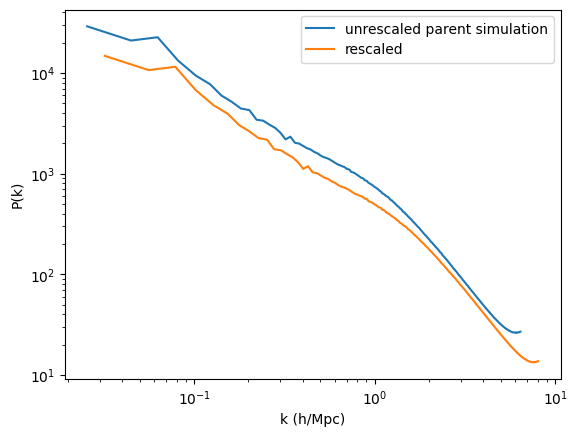

In [ ]:
# Let's rescale the power spectrum
rsc_k, rsc_Pk = np.loadtxt("data/sims/big_sigma/output/pofk_LCDM_cb_z0.298.txt", usecols=(0,1), unpack=True)
plt.loglog( rsc_k, rsc_Pk, label='unrescaled parent simulation' )
rsc_k /= s
rsc_Pk *= s**3
plt.loglog( rsc_k, rsc_Pk, label='rescaled' )
plt.xlabel('k (h/Mpc)')
plt.ylabel('P(k)')
plt.legend()


Now plot the power spectrum of this simulation against those of the starting ΛCDM and $f(R)$ simulations you were provided with:

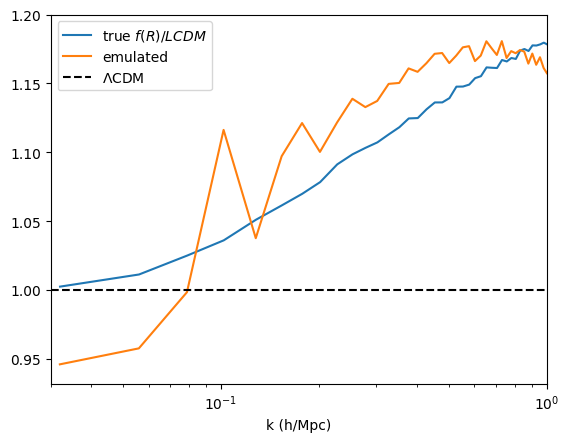

In [ ]:
plt.plot( fofR_k, fofR_Pk / LCDM_Pk, 'C0', label=r"true $f(R)/LCDM$" )
plt.plot( rsc_k, rsc_Pk / LCDM_Pk, 'C1', label=r"emulated" )
plt.axhline( 1, c='k', ls='--', label=r'$\Lambda$CDM')
plt.xlabel('k (h/Mpc)')
plt.ylim( ymax=1.2 )
plt.xlim( 3e-2,1 )
plt.xscale('log')
plt.legend()

The blue line shows the power spectrum of an N-body simulation that was computed under general relativity, yet this rescaling already made it much more similar to the target. However, there is room for improvement.

We know that the Zeldovich Approximation describes the large scales well. We can further displace our particles by ensuring they mean the prescription of the ZA at large scales. *However*: the ZA is only valid at linear scales, so we will need to ensure this treatment is not applied beyond the regime of validity of the ZA! Later in the notebook you'll be able to check what happens if you don't...

Let's estimate the "scale of non-linearity" first, then let's rescale the Lagrangian displacement using Eq. (38) of Mead et al. To obtain the positions, we'll readd it to the Lagrangian grid.

In [ ]:
# rule of thumb for the scale of non-linearity - this is not the criterion used by
# Mead et al, but it's faster and sufficient for our purposes
idx_NL = np.where( fofR_k**3 * fofR_Pk / (2*np.pi**2) > 1)[0][0]
k_NL = fofR_k[idx_NL]
print( f"Scale of non-linearity: ~{k_NL:.2f} h/Mpc" )


Scale of non-linearity: ~0.20 h/Mpc


In [ ]:
def common_quantities( N, L, k_NL, rsc_k, rsc_Pk, tgt_k, tgt_Pk ):

    # frequency modes
    kfreq = np.fft.fftfreq(N) * N
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k_norm = np.sqrt( kx**2 + ky**2 + kz**2 ) * 2*np.pi/L
    del kx, ky, kz

    Gaussian_filter = np.exp( -0.5 * ( k_norm / k_NL )**2 )

    rsc_Pk_interp = interp1d( rsc_k, rsc_Pk )
    tgt_Pk_interp = interp1d( tgt_k, tgt_Pk )

    try:
        # mask 0-mode k=(0,0,0)
        mask = ( k_norm != 0. )
        Pk_factor = np.zeros_like( k_norm )
        # this is equivalent to Eq.(38)
        Pk_factor[mask] = tgt_Pk_interp( k_norm[mask] ) / ( rsc_Pk_interp( k_norm[mask] ) )
    except ValueError:
        # if k_norm has values that the power spectrum FML computed hasn't...
        mask = ( k_norm > np.min( tgt_k ) )
        Pk_factor = np.zeros_like( k_norm )
        # this is equivalent to Eq.(38)
        Pk_factor[mask] = tgt_Pk_interp( k_norm[mask] ) / ( rsc_Pk_interp( k_norm[mask] ) )

    return k_norm, Pk_factor, Gaussian_filter


def rescale_displacements( N, L, k_NL, rsc_boxD_path, rsc_and_disp_boxD_path,
                           rsc_k, rsc_Pk, tgt_k, tgt_Pk ):
    # only the linear part up to now

    boxD = np.load( rsc_boxD_path )
    d_boxD_FT = np.fft.fftn( boxD, axes=(-3, -2, -1))

    Pk_factor, Gaussian_filter  = common_quantities( N, L, k_NL, rsc_k, rsc_Pk, tgt_k, tgt_Pk )[1:]

    # keep only linear component of displacement
    d_boxD_FT *= Gaussian_filter

    # rescale the displacement in a scale-dependent way
    factor = np.sqrt( Pk_factor ) - 1
    d_boxD_FT *= factor

    # inverse Fourier transform
    d_boxD = np.fft.ifftn( d_boxD_FT, axes=(-3, -2, -1)).real
    boxD += d_boxD
    boxD = boxD.astype(np.float32)

    np.save( rsc_and_disp_boxD_path, boxD )


# output file
rsc_and_disp_boxD_path = "rsc_and_disp_boxD.npy"
# input file
rsc_boxD_path = "rsc_boxD.npy"
rescale_displacements( N, L, k_NL, rsc_boxD_path, rsc_and_disp_boxD_path, rsc_k, rsc_Pk, fofR_k, fofR_Pk )

Now, let's rebuild the position from this displacement.

In [ ]:
def boxD_to_D( boxD, normalise=1 ):
    """
    Starting from the displacement in m2m format, return it
    as a (N^3,3) vector
    """

    # infer number of particles from m2mD's shape
    _, N, _, _ = boxD.shape

    D = np.zeros((N**3,3), dtype=np.float32)

    for i in range(3):
        D[:,i] = boxD[i,...].reshape(-1)

    # D *= BoxSize
    D *= normalise

    return D


def build_position( grid_file, disp, L ):
    """
    Get the particle positions given the displacement (in any format) and the Lagrangian grid
    """

    # is the displacement in m2m or (N^3,3) format?
    if disp.shape[0]==3:
        D = boxD_to_D( disp )
    elif disp.shape[-1]==3:
        D = disp
    else:
        raise NotImplementedError


    grid = np.load(grid_file)

    pos = grid + D
    # boundary conditions
    pos = pos % L

    return pos

In [ ]:
rsc_boxD = np.load( rsc_boxD_path )
rsc_and_disp_pos = build_position( grid_file, rsc_boxD, L )

Now let's compute the power spectrum of this new simulation using Pylians. To do so, we must first reconstruct the density field.
NOTE: FML uses the PSC (piecewise cubic spline) mass assignment when reconstructing the density field from particles; this is less noisy than the CIC (cloud in cell) used by Pylians. You should expect the Pylians power spectrum to be much more noisy.

In [ ]:
import Pk_library as PKL
rsc_and_disp_delta = get_delta(pos=rsc_and_disp_pos, MAS="CIC")

Pk = PKL.Pk( rsc_and_disp_delta, L, axis=0, MAS="CIC", verbose=False )
rsc_and_disp_k, rsc_and_disp_Pk = Pk.k3D, Pk.Pk[:,0]

# interpolate the FML LCDM Pk to allow comparison with the one computed by Pylians
LCDM_Pk_interp = interp1d( LCDM_k, LCDM_Pk )

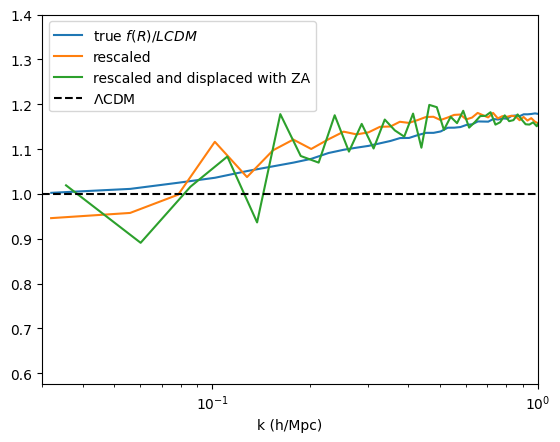

In [ ]:
plt.plot( fofR_k, fofR_Pk / LCDM_Pk, 'C0', label=r"true $f(R)/LCDM$" )
plt.plot( rsc_k, rsc_Pk / LCDM_Pk, 'C1', label="rescaled" )
plt.plot( rsc_and_disp_k, rsc_and_disp_Pk / LCDM_Pk_interp( rsc_and_disp_k ), 'C2', label="rescaled and displaced with ZA")
plt.axhline( 1, c='k', ls='--', label=r'$\Lambda$CDM')
plt.xlabel('k (h/Mpc)')
plt.ylim( ymax=1.4 )
plt.xlim( 3e-2,1 )
plt.xscale('log')
plt.legend()

The algorithm of Mead et al includes a further step where dark matter haloes are restructured to match target relations. This step is not meaningful at the resolution we are using (we're not really resolving haloes), and it depends on the assumptions made on the relation haloes are expected to follow. We will skip it

Now try to set `k_NL` to a large value, so that the Gaussian smoothing is not applied. Plot the snapshot and the power spectrum of the resulting matter distribution? What do you notice?

In [ ]:
# output file
nf_rsc_and_disp_boxD_path = "no_filter_rsc_and_disp_boxD.npy"
# input file
rsc_boxD_path = "rsc_boxD.npy"
k_NL_nf = 3
rescale_displacements( N, L, k_NL_nf, rsc_boxD_path, nf_rsc_and_disp_boxD_path, rsc_k, rsc_Pk, fofR_k, fofR_Pk )
nf_rsc_boxD = np.load( nf_rsc_and_disp_boxD_path )
nf_rsc_and_disp_pos = build_position( grid_file, nf_rsc_boxD, L )
del rsc_boxD

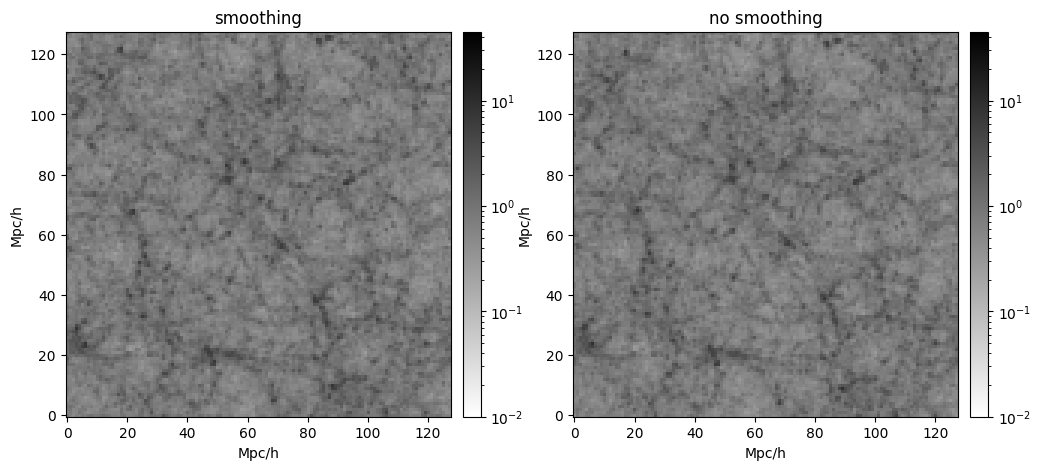

In [ ]:
nf_delta = get_delta( pos=nf_rsc_and_disp_pos )
deltas = [ rsc_and_disp_delta, nf_delta ]
titles = [ 'smoothing', 'no smoothing' ]

fig, axes = plt.subplots(1,2, figsize=(12,5))
for i, delta in enumerate(deltas):
    # average over the third dimension so that we can visualise the slide in 2D
    delta_2D = np.mean( 1 + delta[:,:,z:z+dz], axis=-1 )
    cbar = axes[i].imshow( delta_2D, origin='lower', cmap=gray_cmap, norm=norm )
    cax = fig.add_axes([ axes[i].get_position().x1+0.01, axes[i].get_position().y0,
                    0.015, axes[i].get_position().height])
    plt.colorbar( cbar, cax=cax )
    axes[i].set_xlabel('Mpc/h')
    axes[i].set_ylabel('Mpc/h')
    axes[i].set_title(titles[i])

In [ ]:
delta_2D_smoothed = np.mean(1 + deltas[0][:,:,z:z+dz], axis=-1)
delta_2D_unsmoothed = np.mean(1 + deltas[1][:,:,z:z+dz], axis=-1)
ani = animate_compare( delta_2D_smoothed, delta_2D_unsmoothed, "smoothed", "unsmoothed" )
HTML(ani.to_jshtml())


/tmp/ipython-input-5-2761352489.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray_cmap = cm.get_cmap("gray_r")
/tmp/ipython-input-5-2761352489.py:86: UserWarning: frames=<function animate_compare.<locals>.frame_gen at 0x784d517f2c00> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(


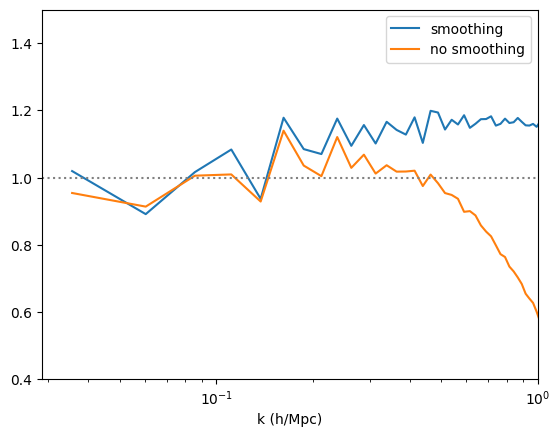

In [ ]:
Pk = PKL.Pk( nf_delta, L, axis=0, MAS="PSC", verbose=False )
nf_k, nf_Pk = Pk.k3D, Pk.Pk[:,0]

plt.plot( rsc_and_disp_k, rsc_and_disp_Pk / LCDM_Pk_interp( rsc_and_disp_k ), label='smoothing' )
plt.plot( nf_k, nf_Pk / LCDM_Pk_interp( nf_k ), label='no smoothing' )
plt.xscale('log')
plt.xlabel('k (h/Mpc)')
plt.ylim( 0.4,1.5)
plt.legend()
plt.xlim(xmax=1);
plt.axhline(1, ls=':', c='gray')